In [21]:
import pandas as pd
import numpy as np
import esm
import gc
import os
from pathlib import Path
import torch, json
from datetime import datetime
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.utils.rnn as rnn_utils
import torch.nn as nn

In [4]:

save_dir = Path("website/backend/weights")
best_acc = -1.0

In [8]:
data = np.load("data/cullpdb+profile_5926_filtered.npy.gz", allow_pickle=True)

In [ ]:
N = data.shape[0]
L, D = 700, 57
arr = data.reshape(N, L, D)
print("arr shape:", arr.shape)

In [9]:
# Amino acid mapping (20 + X + padding)
AA_CODES = list("ACDEFGHIKLMNPQRSTVWY") + ['X'] + ['-']
# Q8 code order from dataset description
Q8_ORDER = ['L','B','E','G','I','H','S','T','-']
# Q8 → Q3 mapping: 0=Helix, 1=Strand, 2=Coil, 3=Padding
Q8_TO_Q3 = np.array([2, 1, 1, 0, 0, 0, 2, 2, 3])

def extract_features_labels(data):
    """
    Extract AA one-hot, N/C terminal flags, and Q3 labels from CullPDB array.
    Returns:
        features: list of np.arrays (n_residues, 24)  # 22 AA + 2 terminal flags
        labels_q3: list of np.arrays (n_residues,)    # Q3 labels (0,1,2)
        sequences: list of str                       # decoded AA sequences
    """
    N = data.shape[0]
    L, D = 700, 57
    arr = data.reshape(N, L, D)

    features = []
    labels_q3 = []
    sequences = []

    for prot in arr:
        # Blocks from dataset description
        aa_onehot = prot[:, 0:22]
        q8_onehot = prot[:, 22:31]
        nc_flags = prot[:, 31:33]  # N-term / C-term

        # Decode Q8 index and mask padding
        q8_idx = q8_onehot.argmax(axis=1)
        mask = q8_idx != 8  # not "NoSeq"

        # Q3 labels
        q3_idx = Q8_TO_Q3[q8_idx]
        q3_idx = q3_idx[mask]  # remove padding

        # Features = AA one-hot + N/C flags
        feat = np.concatenate([aa_onehot[mask], nc_flags[mask]], axis=1)

        # Decode AA sequence (optional, for inspection)
        aa_idx = aa_onehot.argmax(axis=1)
        seq = "".join(AA_CODES[i] for i in aa_idx[mask])

        features.append(feat)
        labels_q3.append(q3_idx)
        sequences.append(seq)

    return features, labels_q3, sequences

In [10]:
features, q3_labels, sequences = extract_features_labels(data)

print("Protein 0:")
print("Sequence:", sequences[0])
print("Features shape:", features[0].shape)  # (len_protein, 24)
print("Q3 labels:", q3_labels[0])

Protein 0:
Sequence: GEYPTWYGANPYFMSTHDMFDRDGWENTMENPIKXWHKAAVFFFYTNSNNWWHNGKWEDRMCENMYGKETEPQMWQXQARYYTMARESHAHQKFPHXAFWDWPMTEEGGAEDKRHRDNYWHQMMXTNWPFAERHMPFKQWWDNQWMTNAFEVRHMQPNGWMYAWKYWNQVIFDYMSSFHEIATWAFTRKEHHSIDPGWDNEDWWNHRTKRXKENMMTMKTKEDRFKEHRYTWSMRGADEFRCTWIRFRPNWWWRFRFKGWRKFDKNRMFFKESNAHYMEYTWNMTENNHPMATKETMWMSTSNWYFFKRMDWWSK
Features shape: (315, 24)
Q3 labels: [2 2 2 2 1 1 1 2 2 2 2 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 0 0 0 0 2 2 1 1 1 1
 1 1 1 1 1 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 2 0 0 0 0 2 2 2 1 1 2 2 2 2 2 1 2
 1 1 2 2 0 0 0 1 1 1 2 2 2 1 1 1 1 2 2 2 2 2 1 1 1 1 1 1 1 1 2 0 0 0 0 0 2
 0 0 0 0 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 2 2 2 1 1 2 2 2 2 2 2 2 2 2
 0 0 0 1 1 1 2 2 2 2 1 1 1 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 1 1 1 1 1 1 1 2 2 2 2 0 0 0 2 1 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 1 1 1 1 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 2 2 2 2 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 0 0 0 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 2 2 1 1 1

In [17]:
class FeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Each feature: (seq_len, 24), label: (seq_len,)
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

def collate_feature_batch(batch):
    feats, labels = zip(*batch)
    feats_padded = rnn_utils.pad_sequence(feats, batch_first=True)
    labels_padded = rnn_utils.pad_sequence(labels, batch_first=True, padding_value=-1)
    lengths = torch.tensor([len(l) for l in labels])
    return feats_padded, labels_padded, lengths

# Prepare dataset and loaders
feature_dataset = FeatureDataset(features, q3_labels)
train_size = int(0.8 * len(feature_dataset))
val_size = len(feature_dataset) - train_size
train_dataset, val_dataset = random_split(feature_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_feature_batch)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_feature_batch)

In [ ]:
# Example: simple linear classifier for each protein
class ProteinClassifier2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.convLayers = nn.Sequential(
            nn.Conv1d(in_channels=24, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=16, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=15, padding=7),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=32, kernel_size=21, padding=10)  # Final conv layer
        )
        self.classifier = nn.Sequential(
            nn.Linear(32, 32),  # 32 is out_channels from last Conv1d
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        # x: (batch, seq_len, embedding_dim)
        x = x.transpose(1, 2)  # (batch, embedding_dim, seq_len) for Conv1d
        x = self.convLayers(x) # (batch, 32, seq_len)
        x = x.transpose(1, 2)  # (batch, seq_len, 32)
        logits = self.classifier(x)  # (batch, seq_len, num_classes)
        return logits

In [32]:
import torch
import torch.nn as nn

def _choose_gn_groups(C: int) -> int:
    # pick a GroupNorm group count that divides C
    for g in (32, 16, 8, 4, 2, 1):
        if C % g == 0:
            return g
    return 1

class SE1D(nn.Module):
    """Squeeze-and-Excitation for 1D feature maps (B, C, L)."""
    def __init__(self, channels: int, reduction: int = 8):
        super().__init__()
        hidden = max(1, channels // reduction)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Conv1d(channels, hidden, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden, channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x: (B, C, L)
        w = self.pool(x)      # (B, C, 1)
        w = self.fc(w)        # (B, C, 1)
        return x * w          # channel-wise reweight

class Inception1DBlock(nn.Module):
    """
    Inception-Style 1D Block:
    - parallel convs (1x1, k=3, k=7, k=3 dilated)
    - same output length via padding
    - Residual + GroupNorm + ReLU + Dropout
    - SE channel attention
    """
    def __init__(self, in_ch, out_ch, dropout=0.1, use_residual=True):
        super().__init__()
        assert out_ch % 4 == 0, "out_ch must be divisible by 4 (4 branches)."
        bch = out_ch // 4  # channels per branch

        # branches
        self.branch_1x1 = nn.Conv1d(in_ch, bch, kernel_size=1, padding=0)
        self.branch_k3  = nn.Conv1d(in_ch, bch, kernel_size=3, padding=1)
        self.branch_k7  = nn.Conv1d(in_ch, bch, kernel_size=7, padding=3)

        dilation = 4
        pad = dilation * (3 - 1) // 2  # = 4
        self.branch_k3_dil4 = nn.Conv1d(in_ch, bch, kernel_size=3, dilation=dilation, padding=pad)

        # normalization + attention + activation
        self.gn = nn.GroupNorm(_choose_gn_groups(out_ch), out_ch)
        self.se = SE1D(out_ch, reduction=8)
        self.act = nn.ReLU(inplace=True)
        self.do  = nn.Dropout(dropout)

        # residual projection if needed
        self.use_residual = use_residual
        self.res_proj = nn.Conv1d(in_ch, out_ch, kernel_size=1) if (use_residual and in_ch != out_ch) else nn.Identity()

    def forward(self, x):
        # x: (B, C_in, L)
        y1 = self.branch_1x1(x)
        y2 = self.branch_k3(x)
        y3 = self.branch_k7(x)
        y4 = self.branch_k3_dil4(x)
        y = torch.cat([y1, y2, y3, y4], dim=1)  # (B, out_ch, L)

        y = self.gn(y)
        if self.use_residual:
            y = y + self.res_proj(x)

        y = self.se(y)          # channel attention
        y = self.act(y)
        y = self.do(y)
        return y

class InceptionProteinClassifier(nn.Module):
    """
    Overall:
    - input (B, L, 24) -> transpose -> (B, 24, L)
    - stack Inception1DBlocks (local + wider contexts)
    - back to (B, L, C) and per-position MLP head
    """
    def __init__(self, num_classes=3, in_feats=24, base_channels=64, num_blocks=3, dropout=0.1):
        super().__init__()
        ch = base_channels

        # stem with GroupNorm
        self.stem = nn.Sequential(
            nn.Conv1d(in_feats, ch, kernel_size=3, padding=1),
            nn.GroupNorm(_choose_gn_groups(ch), ch),
            nn.ReLU(inplace=True),
        )

        # backbone blocks
        self.backbone = nn.Sequential(
            *[Inception1DBlock(ch, ch, dropout=dropout, use_residual=True) for _ in range(num_blocks)]
        )

        # token-wise classifier head
        self.head = nn.Sequential(
            nn.Linear(ch, ch),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(ch, ch // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(ch // 2, num_classes)
        )

    def forward(self, x):
        # x: (B, L, in_feats)
        x = x.transpose(1, 2)    # -> (B, in_feats, L)
        x = self.stem(x)         # -> (B, ch, L)
        x = self.backbone(x)     # -> (B, ch, L)
        x = x.transpose(1, 2)    # -> (B, L, ch)
        logits = self.head(x)    # -> (B, L, num_classes)
        return logits


In [27]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- Sinusoidal positional encoding (parameter-free) ---
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 10000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_len, d_model)              # (max_len, d_model)
        position = torch.arange(0, max_len).float().unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)                  # not trainable

    def forward(self, x):
        # x: (B, L, C)
        L = x.size(1)
        x = x + self.pe[:L].unsqueeze(0)               # broadcast over batch
        return self.dropout(x)

# --- Feed-Forward module (Conformer "macaron" style; scaled by 0.5 inside the block) ---
class FeedForwardModule(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_ff),
            nn.SiLU(),                  # Swish activation
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

# --- Convolution module (depthwise-separable + GLU gate) ---
class ConformerConvModule(nn.Module):
    def __init__(self, d_model: int, kernel_size: int = 15, dropout: float = 0.1):
        super().__init__()
        self.ln = nn.LayerNorm(d_model)
        self.pw_in = nn.Conv1d(d_model, 2 * d_model, kernel_size=1)  # pointwise
        self.glu = nn.GLU(dim=1)                                     # halves channels back to d_model
        self.dw = nn.Conv1d(                                          # depthwise conv over sequence
            d_model, d_model, kernel_size=kernel_size,
            padding=kernel_size // 2, groups=d_model
        )
        self.bn = nn.BatchNorm1d(d_model)
        self.act = nn.SiLU()
        self.pw_out = nn.Conv1d(d_model, d_model, kernel_size=1)     # pointwise
        self.do = nn.Dropout(dropout)

    def forward(self, x):
        # x: (B, L, C)
        x = self.ln(x)
        x = x.transpose(1, 2)                 # -> (B, C, L) for Conv1d
        x = self.pw_in(x)                     # (B, 2C, L)
        x = self.glu(x)                       # (B, C, L)
        x = self.dw(x)                        # (B, C, L)
        x = self.bn(x)
        x = self.act(x)
        x = self.pw_out(x)                    # (B, C, L)
        x = x.transpose(1, 2)                 # -> (B, L, C)
        x = self.do(x)
        return x

# --- Full Conformer block: FFN -> MHSA -> Conv -> FFN (with residuals and norms) ---
class ConformerBlock(nn.Module):
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float, conv_kernel: int = 15):
        super().__init__()
        self.ff1 = FeedForwardModule(d_model, d_ff, dropout)
        self.mhsa_ln = nn.LayerNorm(d_model)
        self.mhsa = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.mhsa_do = nn.Dropout(dropout)
        self.conv = ConformerConvModule(d_model, kernel_size=conv_kernel, dropout=dropout)
        self.ff2 = FeedForwardModule(d_model, d_ff, dropout)
        self.final_ln = nn.LayerNorm(d_model)

    def forward(self, x, key_padding_mask=None):
        # 1) First FFN (macaron) scaled by 0.5 in residual
        x = x + 0.5 * self.ff1(x)

        # 2) Multi-Head Self-Attention with pre-norm
        y = self.mhsa_ln(x)
        # key_padding_mask: shape (B, L), True = PAD to ignore
        y, _ = self.mhsa(y, y, y, key_padding_mask=key_padding_mask, need_weights=False)
        x = x + self.mhsa_do(y)

        # 3) Convolution module (local context)
        x = x + self.conv(x)

        # 4) Second FFN (macaron) scaled by 0.5 in residual
        x = x + 0.5 * self.ff2(x)

        # 5) Final layer norm
        x = self.final_ln(x)
        return x

# --- Conformer encoder + per-token classification head ---
class ConformerProteinClassifier(nn.Module):
    """
    Input:  (B, L, in_feats=24)   # per residue features
    Output: (B, L, num_classes)   # per residue logits (Q3)
    """
    def __init__(
        self,
        num_classes: int = 3,
        in_feats: int = 24,
        d_model: int = 128,
        n_heads: int = 4,
        d_ff: int = 256,
        num_layers: int = 3,
        conv_kernel: int = 15,
        dropout: float = 0.1,
        use_positional_encoding: bool = True,
    ):
        super().__init__()
        self.input_proj = nn.Linear(in_feats, d_model)             # project inputs to model dim
        self.pos_enc = (SinusoidalPositionalEncoding(d_model, dropout)
                        if use_positional_encoding else nn.Identity())

        self.layers = nn.ModuleList([
            ConformerBlock(d_model, n_heads, d_ff, dropout, conv_kernel=conv_kernel)
            for _ in range(num_layers)
        ])

        self.head = nn.Sequential(                                  # token-wise classifier
            nn.Linear(d_model, d_model),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes),
        )

    def forward(self, x, key_padding_mask=None):
        # x: (B, L, in_feats)
        x = self.input_proj(x)                  # (B, L, d_model)
        x = self.pos_enc(x)                     # add positional info
        for layer in self.layers:
            x = layer(x, key_padding_mask=key_padding_mask)
        logits = self.head(x)                   # (B, L, num_classes)
        return logits


In [ ]:

num_classes = 3  # Q3 labels
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = ProteinClassifier2(num_classes).to(device)
model = InceptionProteinClassifier(num_classes=num_classes, in_feats=24, base_channels=64, num_blocks=3, dropout=0.1).to(device)

#model = ConformerProteinClassifier(
#    num_classes=num_classes,
#    in_feats=24,
#    d_model=96,     # try 96–192 depending on GPU
#    n_heads=2,       # d_model must be divisible by n_heads
#    d_ff=192,
#    num_layers=2,    # 2–4 is a good start
#    conv_kernel=9,
#    dropout=0.1
#).to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1, label_smoothing=0.05)

num_epochs = 20
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_feats, batch_labels, batch_lengths in train_loader:
        batch_feats = batch_feats.to(device)        # (B, L, 24)
        batch_labels = batch_labels.to(device)      # (B, L)

        # Mask: True for padding positions
        pad_mask = (batch_labels == -1)              # shape (B, L)

        # Forward pass with mask
        logits = model(batch_feats)
        #logits = model(batch_feats, key_padding_mask=pad_mask)  # (B, L, num_classes)
        loss = criterion(logits.view(-1, num_classes), batch_labels.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {avg_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_feats, batch_labels, batch_lengths in val_loader:
            batch_feats = batch_feats.to(device)
            batch_labels = batch_labels.to(device)
            pad_mask = (batch_labels == -1)
            
            logits = model(batch_feats)
            #logits = model(batch_feats, key_padding_mask=pad_mask)
            loss = criterion(logits.view(-1, num_classes), batch_labels.view(-1))
            val_loss += loss.item()
            preds = logits.argmax(dim=-1)
            mask = batch_labels != -1
            correct += (preds[mask] == batch_labels[mask]).sum().item()
            total += mask.sum().item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = correct / total if total > 0 else 0
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs} - Val loss: {avg_val_loss:.4f} - Val acc: {val_acc:.4f}")

Epoch 1/20 - Train loss: 0.9251
Epoch 1/20 - Val loss: 0.8066 - Val acc: 0.6653
Epoch 2/20 - Train loss: 0.8130
Epoch 2/20 - Val loss: 0.7783 - Val acc: 0.6814
Epoch 3/20 - Train loss: 0.7918
Epoch 3/20 - Val loss: 0.7664 - Val acc: 0.6892
Epoch 4/20 - Train loss: 0.7809
Epoch 4/20 - Val loss: 0.7558 - Val acc: 0.6944
Epoch 5/20 - Train loss: 0.7727
Epoch 5/20 - Val loss: 0.7509 - Val acc: 0.6956
Epoch 6/20 - Train loss: 0.7657
Epoch 6/20 - Val loss: 0.7412 - Val acc: 0.7010
Epoch 7/20 - Train loss: 0.7608
Epoch 7/20 - Val loss: 0.7575 - Val acc: 0.6924
Epoch 8/20 - Train loss: 0.7536
Epoch 8/20 - Val loss: 0.7813 - Val acc: 0.6799
Epoch 9/20 - Train loss: 0.7505
Epoch 9/20 - Val loss: 0.7302 - Val acc: 0.7072
Epoch 10/20 - Train loss: 0.7435
Epoch 10/20 - Val loss: 0.7455 - Val acc: 0.7005
Epoch 11/20 - Train loss: 0.7402
Epoch 11/20 - Val loss: 0.7257 - Val acc: 0.7092
Epoch 12/20 - Train loss: 0.7379
Epoch 12/20 - Val loss: 0.7306 - Val acc: 0.7075
Epoch 13/20 - Train loss: 0.7340
E

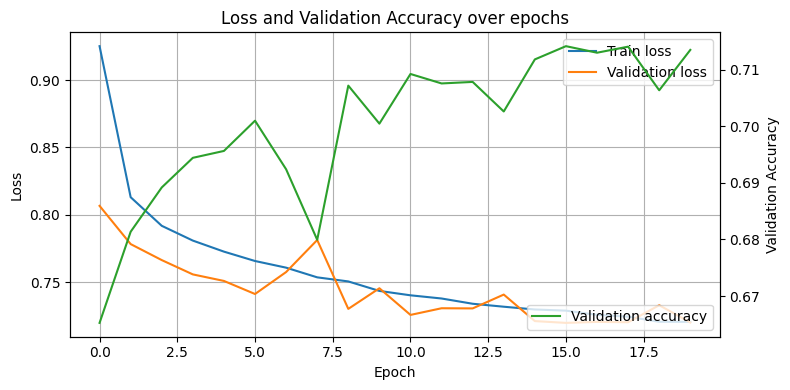

In [35]:
# Plot loss and accuracy
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(train_losses, label="Train loss", color="tab:blue")
ax1.plot(val_losses, label="Validation loss", color="tab:orange")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Loss and Validation Accuracy over epochs")
ax1.legend(loc="upper right")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(val_accuracies, label="Validation accuracy", color="tab:green")
ax2.set_ylabel("Validation Accuracy")
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [36]:
save_dir = Path("website/backend/weights")

ckpt_path = save_dir / "model_weights_.pt"
torch.save({
    "state_dict": model.state_dict(),
    "num_classes": num_classes,
    "arch": "ProteinClassifier2",
    "val_acc": float(best_acc),
    "saved_at": datetime.now().isoformat(timespec="seconds"),
}, ckpt_path)